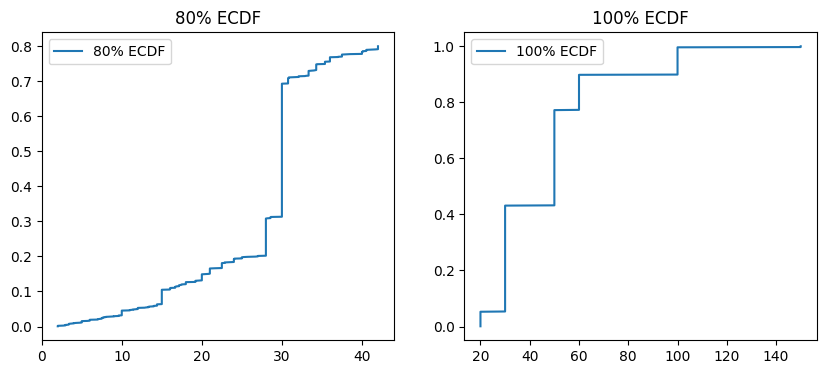

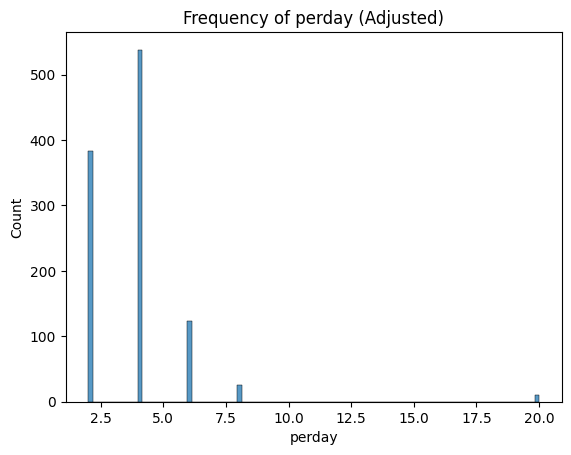

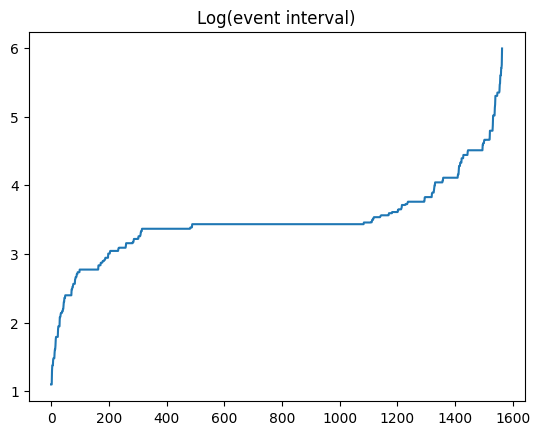

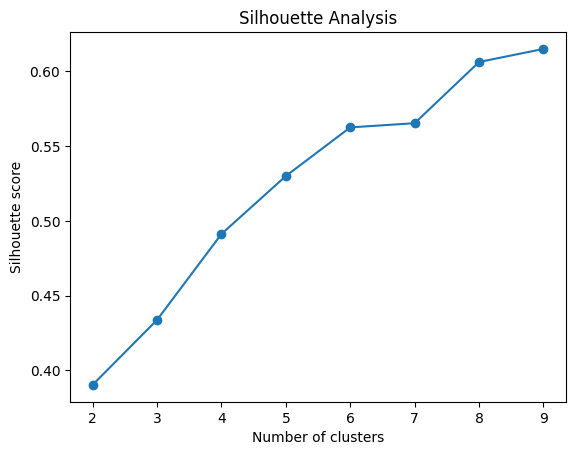

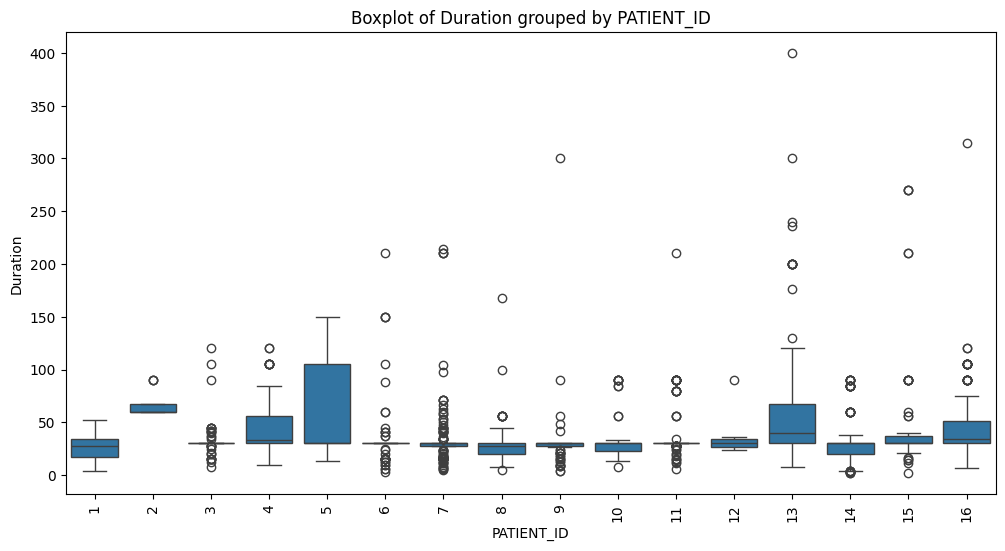

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

# Load datasets
med_events_df = pd.read_csv('../data/med_events_ATC.csv')
tidy_dataset_df = pd.read_csv('../data/tidy_dataset.csv')

# Preprocess med_events_ATC.csv
def preprocess_med_events(df):
    df.columns = df.columns.str.strip()  # Ensure no leading/trailing spaces
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df['DURATION'] = pd.to_numeric(df['DURATION'], errors='coerce')
    df['PERDAY'] = pd.to_numeric(df['PERDAY'], errors='coerce')
    df.dropna(subset=['DURATION', 'PERDAY'], inplace=True)  # Remove rows with NaN values in key columns
    label_encoder = LabelEncoder()
    df['CATEGORY_L1_encoded'] = label_encoder.fit_transform(df['CATEGORY_L1'].astype(str))
    df['CATEGORY_L2_encoded'] = label_encoder.fit_transform(df['CATEGORY_L2'].astype(str))
    return df

med_events_df = preprocess_med_events(med_events_df)

# Preprocess tidy_dataset.csv
def preprocess_tidy_dataset(df):
    df['eksd'] = pd.to_datetime(df['eksd'], errors='coerce')
    df['perday'] = pd.to_numeric(df['perday'], errors='coerce')
    df['dur_original'] = pd.to_numeric(df['dur_original'], errors='coerce')
    df.dropna(subset=['perday', 'dur_original'], inplace=True)  # Remove rows with NaN values in key columns
    label_encoder = LabelEncoder()
    df['ATC_encoded'] = label_encoder.fit_transform(df['ATC'].astype(str))
    return df

tidy_dataset_df = preprocess_tidy_dataset(tidy_dataset_df)

# Select relevant features for clustering
features_med_events = med_events_df[['DURATION', 'PERDAY', 'CATEGORY_L1_encoded', 'CATEGORY_L2_encoded']]
features_tidy_dataset = tidy_dataset_df[['perday', 'dur_original', 'ATC_encoded']]

# Standardize data
scaler = StandardScaler()
scaled_med_events = scaler.fit_transform(features_med_events)
scaled_tidy_dataset = scaler.fit_transform(features_tidy_dataset)

# Apply K-Means
kmeans_med_events = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_tidy_dataset = KMeans(n_clusters=3, random_state=42, n_init=10)

med_events_df['Cluster'] = kmeans_med_events.fit_predict(scaled_med_events)
tidy_dataset_df['Cluster'] = kmeans_tidy_dataset.fit_predict(scaled_tidy_dataset)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
med_events_df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_med_events)

def plot_ecdf(data, title, percentile=None):
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    if percentile:
        max_index = int(len(sorted_data) * (percentile / 100))
        sorted_data = sorted_data[:max_index]
        ecdf = ecdf[:max_index]
    plt.plot(sorted_data, ecdf, label=f'{percentile}% ECDF' if percentile else '100% ECDF')
    plt.legend()
    plt.title(title)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_ecdf(med_events_df['DURATION'], '80% ECDF', 80)
plt.subplot(1, 2, 2)
plot_ecdf(tidy_dataset_df['dur_original'], '100% ECDF')
plt.show()

# Frequency distribution of perday
sns.histplot(tidy_dataset_df['perday'], bins=100)
plt.title('Frequency of perday (Adjusted)')
plt.show()

# Log event interval plot
log_intervals = np.log1p(med_events_df['DURATION'])
plt.plot(sorted(log_intervals))
plt.title('Log(event interval)')
plt.show()

# Silhouette Analysis
sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_med_events)
    sil_scores.append(silhouette_score(scaled_med_events, labels))

plt.plot(range(2, 10), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis')
plt.show()

# Boxplot of Duration grouped by PATIENT_ID
plt.figure(figsize=(12, 6))
sns.boxplot(x='PATIENT_ID', y='DURATION', data=med_events_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Duration grouped by PATIENT_ID')
plt.ylabel('Duration')
plt.xlabel('PATIENT_ID')
plt.show()
